<a href="https://colab.research.google.com/github/mohitydv09/airdraw/blob/main/airdraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import relevant Libraries.

In [9]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import cv2
import os
import random
import math

# Importing Data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
  print("GPU is available. :-)")
else:
  device = 'cpu'
  print("GPU is not available. :-(")

GPU is available. :-)


In [ ]:
def one_hot_encode_local(label):
  # Label is string as A,B,C
  if label == 'A':
    return torch.tensor([1,0,0])
  elif label == 'B':
    return torch.tensor([0,1,0])
  elif label == 'C':
    return torch.tensor([0,0,1])

In [ ]:
root_path = "/content/drive/MyDrive/Data"
train_image_path = os.path.join(root_path,"Train/image")  # pic root path
train_boxes_path = os.path.join(root_path,"Train/bounding_box")  # box root path

test_image_path = os.path.join(root_path,"Test/image")
test_boxes_path = os.path.join(root_path,"Test/bounding_box")

train_image_path_list = []
train_boxes_path_list = []

test_image_path_list = []
test_boxes_path_list = []

# put all image path in image_path_list
for filepath in os.listdir(train_image_path):
    train_image_path_list.append(os.path.join(train_image_path,filepath))

for filepath in os.listdir(test_image_path):
    test_image_path_list.append(os.path.join(test_image_path,filepath))

# put all boxes path in boxes_path_list
for i in train_image_path_list:
    file_name = i.split("/")[-1].split(".")[0]
    file_path = file_name + str(".txt")
    file_path = os.path.join(train_boxes_path, file_path)
    train_boxes_path_list.append(file_path)

for i in test_image_path_list:
    file_name = i.split("/")[-1].split(".")[0]
    file_path = file_name + str(".txt")
    file_path = os.path.join(test_boxes_path, file_path)
    test_boxes_path_list.append(file_path)


train_data = []
test_data = []


for i in range(len(train_image_path_list)):

    img = Image.open(str(train_image_path_list[i]))
    img = np.array(img)
    if img.shape != (480, 640, 3):
        continue
    label = train_image_path_list[i].split("/")[-1].split("-")[0]
    '''Added by Mohit, check later for proper one hot encoding.'''
    label = one_hot_encode_local(label)

    file_name = train_image_path_list[i].split("/")[-1].split(".")[0]
    file_path = file_name + str(".txt")
    file = os.path.join(train_boxes_path, file_path)
    bb1, bb2, bb3, bb4, x = np.loadtxt(str(file), skiprows=1, dtype=None, delimiter=" ", usecols=(0,1,2,3,4), unpack=False)

    train_data.append([img,label,bb1,bb2,bb3,bb4])

for i in range(len(test_image_path_list)):

    img = Image.open(str(test_image_path_list[i]))
    img = np.array(img)
    if img.shape != (480, 640, 3):
        continue
    label = test_image_path_list[i].split("/")[-1].split("-")[0]
    '''Added by Mohit Check later for proper implemention of One Hot encoding.'''
    label = one_hot_encode_local(label)

    file_name = test_image_path_list[i].split("/")[-1].split(".")[0]
    file_path = file_name + str(".txt")
    file = os.path.join(test_boxes_path, file_path)
    bb1, bb2, bb3, bb4, x = np.loadtxt(str(file), skiprows=1, dtype=None, delimiter=" ", usecols=(0,1,2,3,4), unpack=False)

    test_data.append([img,label,bb1,bb2,bb3,bb4])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label, bb1, bb2, bb3, bb4 = self.data[idx]
        bbox = torch.tensor([bb1, bb2, bb3, bb4], dtype=torch.float32)
        return img, label, bbox

In [ ]:
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
for i,batch in enumerate(train_dataloader):
  images, labels, bboxes = batch
  print(f"For batch {i}",images.size())
  print(f"For batch {i}",labels.size())
  print(f"For batch {i}",bboxes.size())
  break

For batch 0 torch.Size([32, 480, 640, 3])
For batch 0 torch.Size([32, 3])
For batch 0 torch.Size([32, 4])
For batch 1 torch.Size([32, 480, 640, 3])
For batch 1 torch.Size([32, 3])
For batch 1 torch.Size([32, 4])
For batch 2 torch.Size([32, 480, 640, 3])
For batch 2 torch.Size([32, 3])
For batch 2 torch.Size([32, 4])
For batch 3 torch.Size([32, 480, 640, 3])
For batch 3 torch.Size([32, 3])
For batch 3 torch.Size([32, 4])
For batch 4 torch.Size([32, 480, 640, 3])
For batch 4 torch.Size([32, 3])
For batch 4 torch.Size([32, 4])
For batch 5 torch.Size([32, 480, 640, 3])
For batch 5 torch.Size([32, 3])
For batch 5 torch.Size([32, 4])
For batch 6 torch.Size([32, 480, 640, 3])
For batch 6 torch.Size([32, 3])
For batch 6 torch.Size([32, 4])
For batch 7 torch.Size([32, 480, 640, 3])
For batch 7 torch.Size([32, 3])
For batch 7 torch.Size([32, 4])
For batch 8 torch.Size([32, 480, 640, 3])
For batch 8 torch.Size([32, 3])
For batch 8 torch.Size([32, 4])
For batch 9 torch.Size([32, 480, 640, 3])
For 

torch.Size([480, 640, 3])


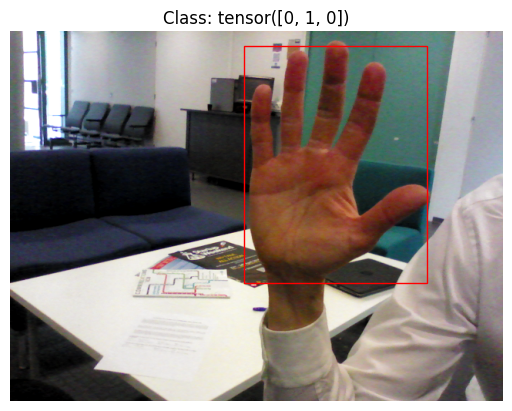

In [ ]:
for batch in test_dataloader:
    images, labels, bboxes = batch
    for i in range(1):
        print(images[i].shape)
        plt.imshow(images[i])
        plt.title(f'Class: {labels[i]}')
        plt.gca().add_patch(plt.Rectangle((bboxes[i][0], bboxes[i][1]), bboxes[i][2], bboxes[i][3], linewidth=1,
                                      edgecolor='r', facecolor='none'))  # Add bounding box to the plot
        plt.axis('off')
        plt.show()

    break

In [ ]:
import torch

# Load the checkpoint file
checkpoint_path = 'YOLO_small.ckpt'
checkpoint = torch.load(checkpoint_path)

# Print the contents of the checkpoint
print(checkpoint.keys())

UnpicklingError: invalid load key, '\x00'.

# CNN Model 1. Name : BasicCNN

Trail of a basic CNN model mentioned with two diffrent heads for Classification and Regression.

Model Sourse : https://miro.medium.com/v2/resize

Image Source : https://miro.medium.com/v2/resize:fit:720/format:webp/1*ux-vHcQdqTFkdfETYCz-5Q.jpeg

![Network Implementation](https://miro.medium.com/v2/resize:fit:720/format:webp/1*ux-vHcQdqTFkdfETYCz-5Q.jpeg)



### Model Architecture.

In [ ]:
class BasicCNN(nn.Module):
  def __init__(self):
    super(BasicCNN, self).__init__()
    ## input_image_size = (480, 640, 3)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

    self.fc_class1 = nn.Linear(64*60*80, 128)
    self.fc_class2 = nn.Linear(128, 3)

    self.fc_reg1 = nn.Linear(64*60*80, 128)
    self.fc_reg2 = nn.Linear(128, 64)
    self.fc_reg3 = nn.Linear(64, 32)
    self.fc_reg4 = nn.Linear(32, 4)

  def forward(self, x):
    x = x.float()
    x = x.permute(0,3,1,2)
    x = self.conv1(x)       ## 16, 480, 640
    x = F.relu(x)           ## 16, 480, 640
    x = self.maxpool(x)     ## 16, 240, 320.
    x = self.conv2(x)       ## 32, 240, 320.
    x = F.relu(x)           ## 32, 240, 320.
    x = self.maxpool(x)     ## 32, 120, 160.
    x = self.conv3(x)       ## 64, 120, 160.
    x = F.relu(x)           ## 64, 120, 160.
    x = self.maxpool(x)     ## 64,  60,  80.
    x = x.reshape(x.size(0),-1)      ## 307200

    ## From here divide into two heads.

    ## Classification head.
    x_class = self.fc_class1(x) ## 128
    x_class = F.relu(x_class)   ## 128
    x_class = self.fc_class2(x_class) ## 3
    x_class = F.softmax(x_class,dim=1)

    ## Regression Head.
    x_reg = self.fc_reg1(x)     ## 128
    x_reg = F.relu(x_reg)       ## 128
    x_reg = self.fc_reg2(x_reg)     ## 64
    x_reg = F.relu(x_reg)       ## 64
    x_reg = self.fc_reg3(x_reg)     ## 32
    x_reg = F.relu(x_reg)       ## 32
    x_reg = self.fc_reg4(x_reg)     ## 4

    return x_reg, x_class

### Model definition, parameters and layer Freezing.

In [ ]:
model = BasicCNN()
## Transfer the model to GPU if available.
model = model.to(device)

In [ ]:
total_params_basicCNN = sum([p.numel() for p in model.parameters()])
print(f"Created model has total of {total_params_basicCNN:,} parameters.")

Created model has total of 78,677,895 parameters.


Set the Loss and optimizer.

In [ ]:
## Set up Loss.
criterion_class = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()

## Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

Layer Freezing for transfer learning.

In [ ]:
## Transfer Learning

### Training Loop

In [ ]:
# Training loop for model.
num_epochs = 50

losses = []
loss_running_trail = []
loss_running_class = []
loss_running_reg = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        ## Send the data to GPU.
        if device == "cpu":
          inputs, labels, bboxs = data
        else:
          inputs, labels, bboxs = data[0].to(device), data[1].to(device), data[2].to(device)

        # Zero the parameter gradients.
        optimizer.zero_grad()

        ## Forward Pass.
        output_reg, output_class = model(images)

        ## Calculate Loss
        loss_class = criterion_class(output_class, labels.float())  ## ~1.5
        loss_reg = criterion_reg(output_reg, bboxs)                 ## ~1000

        ## Backward Pass
        alpha = 0.999
        total_loss = alpha*loss_class + (1-alpha)*loss_reg
        total_loss.backward()

        ## Update the Parameters as per the provided optimizer.
        optimizer.step()

        running_loss += total_loss.item()
        loss_running_trail.append(running_loss)
        loss_running_class.append(loss_class)
        loss_running_reg.append(loss_reg)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / 100:.4f}')
    losses.append(running_loss)
    if len(losses) > 2:
      if (losses[-2]-losses[-1])/losses[-2] < 0.01:
        print("Loss decrease was less than 1 %, hence stopping the training.")
        break

print('Finished Training')

Epoch [1/50], Loss: 2.8823
Epoch [2/50], Loss: 1.0941
Epoch [3/50], Loss: 0.9183
Epoch [4/50], Loss: 0.7191
Epoch [5/50], Loss: 0.5075
Epoch [6/50], Loss: 0.3801
Epoch [7/50], Loss: 0.2986
Epoch [8/50], Loss: 0.2643
Epoch [9/50], Loss: 0.2398
Epoch [10/50], Loss: 0.2260
Epoch [11/50], Loss: 0.2201
Epoch [12/50], Loss: 0.2144
Epoch [13/50], Loss: 0.2083
Epoch [14/50], Loss: 0.2044
Epoch [15/50], Loss: 0.2030
Epoch [16/50], Loss: 0.2026
Epoch [17/50], Loss: 0.2022
Epoch [18/50], Loss: 0.2003
Epoch [19/50], Loss: 0.1991
Epoch [20/50], Loss: 0.1986
Epoch [21/50], Loss: 0.1981


### Save the Model.

In [10]:
torch.save(model,"/content/drive/MyDrive/BasicCNN_model.pth")

## Plot Losses.

In [ ]:
# Plot the loss.
plt.plot(np.arange(len(losses[5:])),losses[5:])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

NameError: name 'losses' is not defined

## Testing of Model.

Load the presaved model.

In [ ]:
model = torch.load('BasicCNN_model.pth')

### Output on testing Data.

In [ ]:
## Write code to Run Quantitative analysis on test Data.


### Visualize the results on test images.

In [ ]:
## Write code to visualize the results on test images, maybe have 5,6 images randomly make inference on them and make a plot.


In [ ]:
for batch in test_dataloader:
    images, labels, bboxes = batch
    for i in range(1):
        print(images[i].shape)
        plt.imshow(images[i])
        plt.title(f'Class: {labels[i]}')
        rect_gt = plt.gca().add_patch(plt.Rectangle((bboxes[i][0], bboxes[i][1]), bboxes[i][2], bboxes[i][3], linewidth=1,
                                      edgecolor='r', facecolor='none',label='GT'))  # Add bounding box to the plot
        # plt.text(rect_gt.get_xy()[0],rect_gt.get_xy()[0], "GT", color='r')
        print("Original Reg box : ",bboxes[i])

        with torch.no_grad(): ## This helps in not having a backprob layer.
          model.eval()        ## This help in running dropout and batchnorm properly.
          output_reg, output_class = model(images[i].unsqueeze(0))
          print("Output reg : ",output_reg,"Output Class : ", output_class)

        plt.gca().add_patch(plt.Rectangle((output_reg[0][0], output_reg[0][1]), output_reg[0][2], output_reg[0][3], linewidth=1,
                                      edgecolor='b', facecolor='none'))  # Add bounding box to the plot
        plt.axis('off')
        plt.show()
        break
    break

### Inference on custom Image.

In [ ]:
## Write code to make inference on a custom Image.


### Inference on webcam feed.

In [ ]:
## Write code to make inference on live feed from webcame.

In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

# Initialize the webcam
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not open webcam")
    exit()

# Main loop to capture frames from the webcam
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        print("Error: Failed to capture frame")
        break

    # Convert the frame to tensor format
    frame_tensor = torch.tensor(frame).permute(2, 0, 1).float() / 255.0  # Convert to tensor format

    # Perform inference
    with torch.no_grad():
        model.eval()
        output_reg, output_class = model(frame_tensor.unsqueeze(0))

    # Convert tensor outputs to numpy arrays
    output_reg = output_reg.numpy()
    output_class = output_class.numpy()

    # Display the frame with bounding boxes
    plt.imshow(frame)
    plt.axis('off')

    # Assuming output_reg and output_class contain the bounding box coordinates and class predictions
    for i in range(len(output_reg)):
        x, y, w, h = output_reg[i]  # Extract bounding box coordinates
        class_label = output_class[i]  # Extract class label

        # Plot bounding box
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='b', facecolor='none'))
        plt.text(x, y - 10, f'Class: {class_label}', color='b', fontsize=10)

    # Display the frame with bounding boxes
    plt.show()

    # Check for 'q' key press to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


Comments on Results.

* The output seems good for this and that.

# Yolo Vivian

Hyperparmerts:
dahfadf
afjafa
adhfal

In [ ]:
#TODO create cnn class with custom layers from yolo
class CBS(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation=nn.SiLU):
    super(CBS, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    self.bn = nn.BatchNorm2d(out_channels)
    self.activation = activation()
  def forward(self, input):
    x = self.conv(input)
    x = self.bn(x)
    x = self.activation(x)
    return x

class c3(nn.Module):
  def __init__(self, in_channels):
    self.resize = nn.Conv2d(in_channels = in_channels, out_channels=in_channels/4, kernel_size=1, activation=nn.PReLu) #use 1x1 kernel for the concentration
    self.d2 = nn.Conv2d(
      in_channels=in_channels//4,
      out_channels=in_channels//4,
      kernel_size=3,
      stride=1,
      padding=2,  #same as dilation
      dilation=2
    )
    self.d4 = nn.Conv2d(
      in_channels=in_channels//4,
      out_channels=in_channels//4,
      kernel_size=3,
      stride=1,
      padding=4,  #same as dilation
      dilation=4
    )
    self.d8 = nn.Conv2d(
      in_channels=in_channels//4,
      out_channels=in_channels//4,
      kernel_size=3,
      stride=1,
      padding=8,  #same as dilation
      dilation=8
    )
    self.d16 = nn.Conv2d(
      in_channels=in_channels//4,
      out_channels=in_channels//4,
      kernel_size=3,
      stride=1,
      padding=16,  #same as dilation
      dilation=16
    )
  def forward(self, input):
    concat = self.resize(input)
    block1 = self.d2(concat)
    block2 = self.d4(concat)
    block3 = self.d8(concat)
    block4 = self.d16(concat)
    total = torch.cat([block1, block2, block3, block4], dim=1 ) #result should be of same shape as input. concatenate based on channel dimension
    result = input + total
    return result

#TODO train model

# Yolo by ChatGPT

In [ ]:
import torch
import torch.nn as nn

class YOLOv1(nn.Module):
    def __init__(self, num_classes):
        super(YOLOv1, self).__init__()
        self.num_classes = num_classes

        # Backbone (Darknet-19)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(192, 128, kernel_size=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=1)
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(512, 256, kernel_size=1)
        self.conv10 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(512, 256, kernel_size=1)
        self.conv12 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(512, 256, kernel_size=1)
        self.conv14 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv15 = nn.Conv2d(512, 512, kernel_size=1)
        self.conv16 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv17 = nn.Conv2d(1024, 512, kernel_size=1)
        self.conv18 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv19 = nn.Conv2d(1024, 512, kernel_size=1)
        self.conv20 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv21 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1)
        self.conv23 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.conv24 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(7*7*1024, 4096)
        self.fc2 = nn.Linear(4096, 7*7*(5 + num_classes))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = torch.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = self.maxpool3(x)
        x = torch.relu(self.conv7(x))
        x = torch.relu(self.conv8(x))
        x = torch.relu(self.conv9(x))
        x = torch.relu(self.conv10(x))
        x = torch.relu(self.conv11(x))
        x = torch.relu(self.conv12(x))
        x = torch.relu(self.conv13(x))
        x = torch.relu(self.conv14(x))
        x = torch.relu(self.conv15(x))
        x = torch.relu(self.conv16(x))
        x = self.maxpool4(x)
        x = torch.relu(self.conv17(x))
        x = torch.relu(self.conv18(x))
        x = torch.relu(self.conv19(x))
        x = torch.relu(self.conv20(x))
        x = torch.relu(self.conv21(x))
        x = torch.relu(self.conv22(x))
        x = torch.relu(self.conv23(x))
        x = torch.relu(self.conv24(x))
        x = x.view(-1, 7*7*1024)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example usage:
model = YOLOv1(num_classes=20)  # Example with 20 classes
input_tensor = torch.randn(1, 3, 416, 416)  # Assuming 416x416 RGB images
output = model(input_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1225])


In [ ]:
yolo_model = YOLOv1(15)
total_params_yolo = sum(p.numel() for p in yolo_model.parameters())

In [ ]:
total_params_yolo

269696020

# YoloV1 implementation

In [ ]:
class yoloV1(nn.Module):
  def __init__(self):
    super(yoloV1, self).__init__()
    ## input_image_size = (480, 640, 3)

    #first block
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding='valid')
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    #second block
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    #third block
    self.conv3 = nn.Conv2d(in_channels=192, out_channels=128, kernel_size=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
    self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    #fourth block
    #do these 4 times
    self.conv7 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1)
    self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)

    self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1)
    self.conv10 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3)
    self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    #fifth block
    #do these 2 times
    self.conv11 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1)
    self.conv12  = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3)

    self.conv13  = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3)
    self.conv14  = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=2)

    #sixth block
    self.conv15  = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3)
    self.conv16  = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3)

    #CHECK THIS CODE
    # Define fully connected layers for classification
    self.fc_class1 = nn.Linear(1024 * 7 * 7, 4096)
    self.fc_class2 = nn.Linear(4096, 1470)  # Output size matches the YOLO output size

    # Define fully connected layers for regression
    self.fc_reg1 = nn.Linear(1024 * 7 * 7, 4096)
    self.fc_reg2 = nn.Linear(4096, 4096)
    self.fc_reg3 = nn.Linear(4096, 16384)  # Output size for bounding box coordinates (4 * 4096)
    #CHECK THIS CODE


    # self.fc_class1 = nn.Linear(64*60*80, 128)
    # self.fc_class2 = nn.Linear(128, 3)

    # self.fc_reg1 = nn.Linear(64*60*80, 128)
    # self.fc_reg2 = nn.Linear(128, 64)
    # self.fc_reg3 = nn.Linear(64, 32)
    # self.fc_reg4 = nn.Linear(32, 4)

  def forward(self, x):
    x = x.float()
    x = x.permute(0,3,1,2)
    x = self.conv1(x)         ## 16, 480, 640
    x = F.relu(x)             ## 16, 480, 640
    x = self.maxpool1(x)      ## 16, 240, 320.
    x = self.conv2(x)         ## 32, 240, 320.
    x = F.relu(x)             ## 32, 240, 320.
    x = self.maxpool(x)       ## 32, 120, 160.
    x = self.conv3(x)         ## 64, 120, 160.
    x = F.relu(x)             ## 64, 120, 160.
    x = self.maxpool(x)       ## 64,  60,  80.
    x = x.reshape(x.size(0),-1)      ## 307200

    ## From here divide into two heads.

    ## Classification head.
    x_class = self.fc_class1(x) ## 128
    x_class = F.relu(x_class)   ## 128
    x_class = self.fc_class2(x_class) ## 3
    x_class = F.softmax(x_class,dim=1)

    ## Regression Head.
    x_reg = self.fc_reg1(x)     ## 128
    x_reg = F.relu(x_reg)       ## 128
    x_reg = self.fc_reg2(x_reg) ## 64
    x_reg = F.relu(x_reg)       ## 64
    x_reg = self.fc_reg3(x_reg) ## 32
    x_reg = F.relu(x_reg)       ## 32
    x_reg = self.fc_reg4(x_reg) ## 4

    return x_reg, x_class

Results:
Commetts